In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Retina mode
from latexify import latexify, format_axes
from MakeDataset import X_train, X_test, y_train, y_test

Matplotlib is building the font cache; this may take a moment.


In [2]:
import warnings
# Suppressing all FutureWarnings and UserWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# Printing versions of libraries used
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,seaborn,scikit-learn,tsfel

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.26.0

numpy       : 1.26.4
pandas      : 2.2.2
matplotlib  : 3.9.1.post1
seaborn     : 0.13.2
scikit-learn: 1.5.1
tsfel       : 0.1.7



# Question 1
#### Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]

In [4]:
#Organizing the collected data into a 3d numpy array:

# Defining the root directory
root_dir = "Collected Data"

# Activity mapping
activity_labels = {
    "WALKING": 1,
    "WALKING_UPSTAIRS": 2,
    "WALKING_DOWNSTAIRS": 3,
    "SITTING": 4,
    "STANDING": 5,
    "LAYING": 6
}

# List to store 2D numpy arrays and labels
data_array_list = []
y_data = []

for subject in os.listdir(root_dir):
    subject_dir = os.path.join(root_dir, subject)
    for activity in os.listdir(subject_dir):
        activity_dir = os.path.join(subject_dir, activity)
        file_path = os.path.join(activity_dir, 'accelerometer.csv')
        
        df = pd.read_csv(file_path)
        df = df.iloc[:, 1:-1]
        df = df*9.8
        array_2d = df.to_numpy()
        
        data_array_list.append(array_2d)
        y_data.append(activity_labels[activity])

# Stacking the 2D arrays into a 3D numpy array
X_data = np.stack(data_array_list)
y_data = np.array(y_data)

print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)

Shape of X_data: (18, 500, 3)
Shape of y_data: (18,)


In [5]:
# function to fit, predict and print metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print()
    print("Confusion Matrix:")

    latexify(fig_width=8)
    activity_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_names)
    cm_display.plot(values_format='d', cmap='Blues', ax=plt.gca())
    plt.xticks(rotation=90)
    plt.show()

I am selecting the TSFEL-featurized data from the UCI dataset while ensuring that test data is similar to train data. I chose this dataset for training because it achieved the best performance in task 2, where we were asked to train and evaluate different models.

In [6]:
#function to obtain features using tsfel on input data
def obtain_features(X, cfg):
    # List to hold DataFrames for all samples
    tsfel_features_list = []

    for sample in X:
        # Each sample is a time series of shape (500,3)
        sample_features = tsfel.time_series_features_extractor(cfg, sample, verbose=0)
        tsfel_features_list.append(sample_features)

    # Concatenating all the individual sample feature DataFrames into one DataFrame
    tsfel_features_df = pd.concat(tsfel_features_list, axis=0, ignore_index=True)
    
    return tsfel_features_df

In [7]:
cfg = tsfel.get_features_by_domain()  # Choosing all statistical, temporal, and spectral features
X_train_tsfel = obtain_features(X_train, cfg)
X_data_tsfel = obtain_features(X_data, cfg)

In [8]:
print(X_train_tsfel.shape)
print(X_data_tsfel.shape)
print(y_train.shape)
print(y_data.shape)

(126, 1152)
(18, 1152)
(126,)
(18,)


In [9]:
# Standardizing the data 
scaler_1 = StandardScaler()
X_train_tsfel_scaled = scaler_1.fit_transform(X_train_tsfel)

scaler_2 = StandardScaler()
X_data_tsfel_scaled = scaler_2.fit_transform(X_data_tsfel)

Accuracy: 0.33
Precision: 0.44
Recall: 0.33

Confusion Matrix:


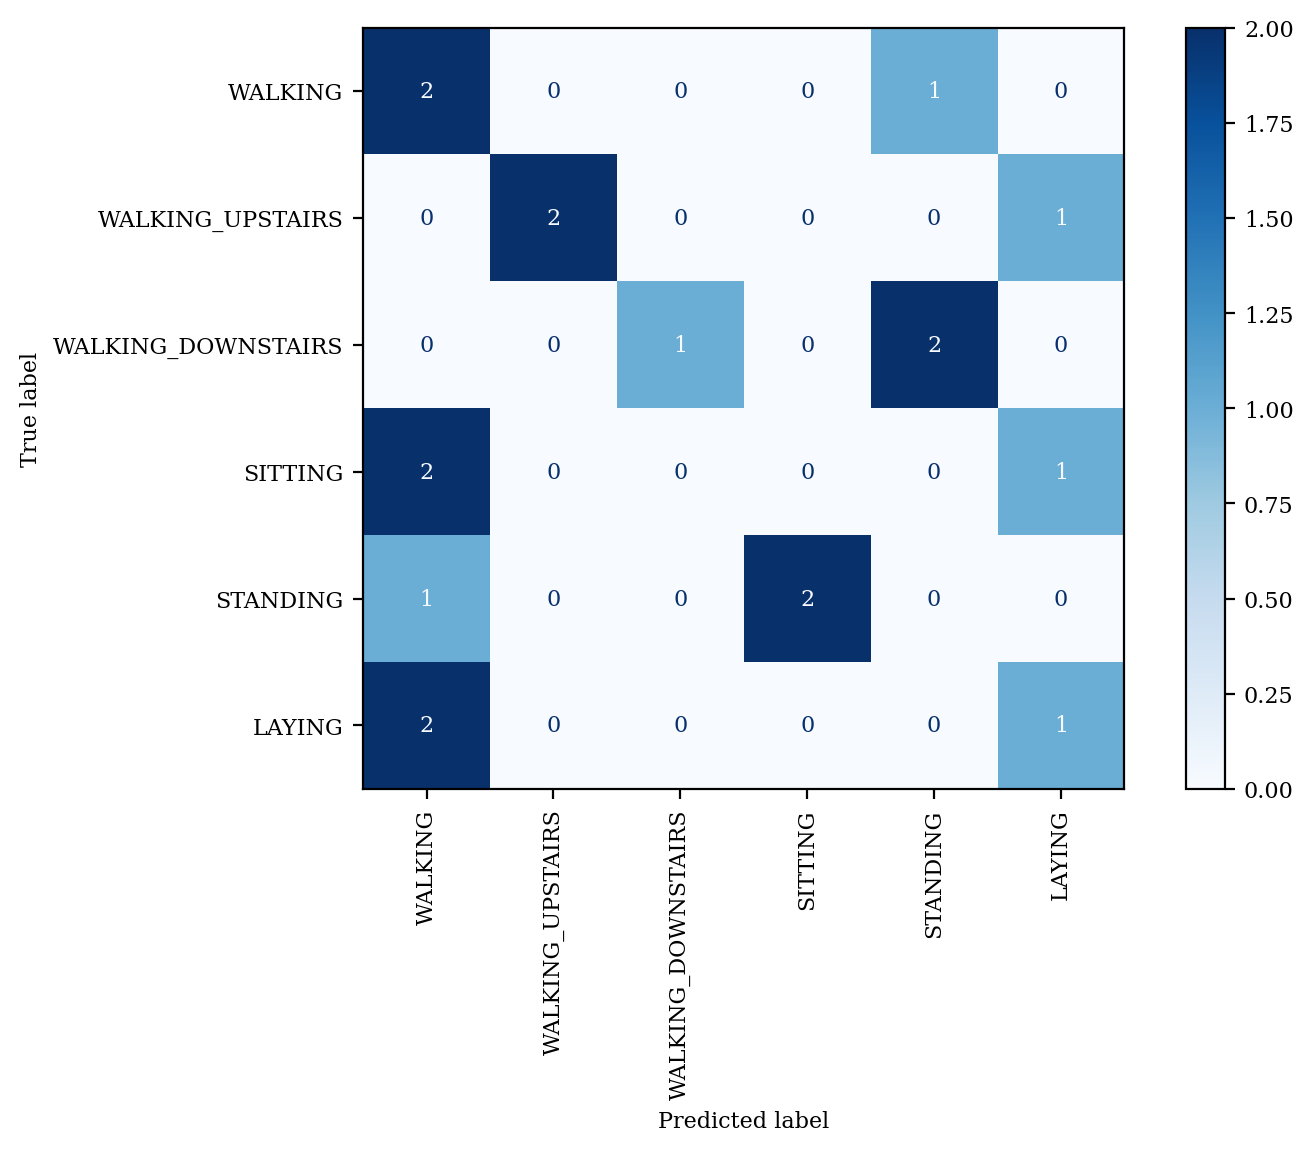

In [10]:
model_1 = DecisionTreeClassifier(random_state=42,class_weight='balanced')
evaluate_model(model_1,X_train_tsfel_scaled, X_data_tsfel_scaled, y_train, y_data )

# Question 2
#### Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? [1 marks]

I preprocessed the collected data by first trimming each activity's readings to ensure that exactly 500 readings were retained per activity per subject. I then organized this trimmed data into a 3D NumPy array with the shape (number of samples, number of time steps, number of features). Since we collected a total of 18 samples, the resulting shape of the training data is (18, 500, 3). Following this, I used the TSFEL-featurized version of the UCI dataset to train the model and tested it on the TSFEL-featurized version of the data we collected.

#### How did the model perform?
The model struggled to accurately predict the activities in your collected data. This is evident from the low accuracy, precision, and recall, as well as the confusion matrix, which shows significant misclassification across various activities. Given that this data was collected "in the wild," outside of controlled conditions, it's possible that factors such as noise, environmental variability, and inconsistent activity patterns affected the model's performance. Overall, the model performance is sub-optimal.

# Question 3
Use the Few-Shot prompting method using UCI-HAR dataset to predict the activities that you performed. Ensure that both your examples and test query undergo similar preprocessing. How did the model perform?

In [11]:
# Importing the api key
from langchain_groq.chat_models import ChatGroq
import sec
key = sec.key

# setting up the model to use
Groq_Token = key

groq_models = {"llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}
model = 'llama3.1-70b'
# model = "gemma-9b"

ACTIVITIES = {
    1: 'WALKING'            ,
    2: 'WALKING_UPSTAIRS'   ,
    3: 'WALKING_DOWNSTAIRS' ,
    4: 'SITTING'            ,
    5: 'STANDING'           ,
    6: 'LAYING'             ,
}

In [12]:
X_train_tsfel

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,2_Wavelet variance_0,2_Wavelet variance_1,2_Wavelet variance_2,2_Wavelet variance_3,2_Wavelet variance_4,2_Wavelet variance_5,2_Wavelet variance_6,2_Wavelet variance_7,2_Wavelet variance_8,2_Zero crossing rate
0,428.119592,4.504459,5.0,85.795509,2.502542,100.0,400.0,0.737727,1.086936,0.002,...,0.003322,0.019687,0.049441,0.092600,0.146952,0.206732,0.257520,0.283238,0.278961,0.0
1,32.768542,1.276929,26.0,6.566842,2.477941,100.0,400.0,0.249165,0.262091,0.002,...,0.000828,0.002949,0.006456,0.011349,0.017532,0.024986,0.033706,0.043662,0.054780,0.0
2,478.627177,4.882182,5.0,95.917270,2.494835,100.0,400.0,0.975656,0.980947,0.002,...,0.000127,0.000487,0.001049,0.001795,0.002722,0.003826,0.005097,0.006514,0.008064,0.0
3,477.002571,4.747669,5.0,95.591698,2.505107,100.0,400.0,0.762545,1.075617,0.002,...,0.002664,0.013335,0.032745,0.056265,0.077145,0.097067,0.119095,0.141653,0.162081,2.0
4,530.466450,5.002581,6.0,106.305902,2.498989,100.0,400.0,0.770530,1.234635,0.002,...,0.002535,0.015177,0.040367,0.069588,0.099245,0.131172,0.159307,0.173780,0.171967,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,497.739114,4.877595,3.0,99.747317,2.472182,100.0,400.0,0.784800,1.202131,0.002,...,0.009342,0.034796,0.057884,0.100034,0.153607,0.202996,0.225477,0.211677,0.172606,10.0
122,340.897228,4.103581,84.0,68.316078,2.297769,100.0,400.0,0.776342,0.926267,0.002,...,0.000305,0.001307,0.003269,0.006416,0.010984,0.016855,0.023610,0.030696,0.037616,0.0
123,17.727040,0.939261,43.0,3.552513,2.506691,100.0,400.0,0.183463,0.192260,0.002,...,0.001052,0.003667,0.007924,0.013976,0.021732,0.031070,0.041836,0.053900,0.067207,0.0
124,430.187347,4.514342,5.0,86.209889,2.457373,100.0,400.0,0.732451,1.062091,0.002,...,0.004605,0.020702,0.042012,0.073398,0.119603,0.177105,0.233516,0.276743,0.303233,8.0


In [13]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standardize both the datasets
X_scaled = scaler.fit_transform(X_train_tsfel)
X_data_scaled = scaler.fit_transform(X_data_tsfel)


# Perform PCA 
pca = PCA(n_components=2)

X_train_tsfel_pca = pca.fit_transform(X_scaled)
X_test_tsfel_pca = pca.transform(X_data_scaled)


In [14]:

# This code block processes the dataset made by makedataset and breaks it into activity wise 
# Taking the mean column wise for to ensure that all samples have contibution in training and avoiding bias if any
activity_1_train = X_train_tsfel_pca[np.where(y_train == 1)].mean(axis=0)
activity_2_train = X_train_tsfel_pca[np.where(y_train == 2)].mean(axis=0)
activity_3_train = X_train_tsfel_pca[np.where(y_train == 3)].mean(axis=0)
activity_4_train = X_train_tsfel_pca[np.where(y_train == 4)].mean(axis=0)
activity_5_train = X_train_tsfel_pca[np.where(y_train == 5)].mean(axis=0)
activity_6_train = X_train_tsfel_pca[np.where(y_train == 6)].mean(axis=0)


X_test_tsfel_pca.shape

(18, 2)

In [15]:
# This code block along with the next block calculates the accuracy of few  shot on the test data made by MakeDataset.py

# Predictions array to store the predictions made by the model
# idsx array to store the indexes of the values that are predicted without any errors
predictions = []
idxs = []

# Looping through the test data and applying zero shot one by one on each sample
for i in range(X_test_tsfel_pca.shape[0]):
    feed = X_test_tsfel_pca[i]
    
    query = f"""
Organisation of data:
The data of humans performing the below mentioned six activities is recorded. The data contained the accelerations in x axis, y axis and z axis.
Then the data is processed using the tsfel library and new features are created out of the given features. 
Then PCA is conducted on the data to reduce the feature to 5.
You are provided with this processed data for each activity.

1.WALKING
{activity_1_train}

2.WALKING_UPSTAIRS
{activity_2_train}

3.WALKING_DOWNSTAIRS
{activity_3_train}

4.SITTING
{activity_4_train}

5.STANDING
{activity_5_train}

6.LAYING
{activity_6_train}


Your task is to analyse the data and give predictions for the below given data from the activity.
Your response should not contain any other explanation just answer in format e.g. 2.WALKING_UPSTAIRS

{feed}

""" 
    
    model_name = model
    llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
    answer = llm.invoke(query)
    
    print(answer.content)
    words = answer.content.split(".")
    required = words[-1].split(":")[-1]
    predictions.append(words[0])
    idxs.append(i)
    print("Predicted: ",predictions[-1])
    print("Actual: ",y_data[i])
    print()
        


1.WALKING
Predicted:  1
Actual:  6

1.WALKING
Predicted:  1
Actual:  4

6.LAYING
Predicted:  6
Actual:  5

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  1

3.WALKING_DOWNSTAIRS
Predicted:  3
Actual:  3

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  2

3.WALKING_DOWNSTAIRS
Predicted:  3
Actual:  6

5.STANDING
Predicted:  5
Actual:  4

5.STANDING
Predicted:  5
Actual:  5

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  1

3.WALKING_DOWNSTAIRS
Predicted:  3
Actual:  3

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  2

1.WALKING
Predicted:  1
Actual:  6

5.STANDING
Predicted:  5
Actual:  4

5.STANDING
Predicted:  5
Actual:  5

1.WALKING
Predicted:  1
Actual:  1

3.WALKING_DOWNSTAIRS
Predicted:  3
Actual:  3

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  2



In [16]:
# Checking the predictions data
predictions = [int(i) for i in predictions]
print(predictions)
print(y_data[idxs])
print("\n\n")

y_test_filtered = y_data[idxs]

# Calculate the number of correct predictions
correct_predictions = sum(p == y for p, y in zip(predictions, y_test_filtered))

# Calculate the accuracy
accuracy = correct_predictions / len(predictions)

# Print the accuracy
print(f"Total Accuracy of few shot: {accuracy:.2%}")




# Calculating the accuracy of the static and dynamic activities separately to analyse the results 

dynamic_test = []
dynamic_predict = []

static_test = []
static_predict = []

for i in range(len(y_test_filtered)):
    if y_test_filtered[i] in [1,2,3]:
        dynamic_predict.append(predictions[i])
        dynamic_test.append(y_test_filtered[i])
    
    if y_test_filtered[i] in [4,5,6]:
        static_predict.append(predictions[i])
        static_test.append(y_test_filtered[i])


dynamic_accuracy = sum(p == y for p,y in zip(dynamic_predict,dynamic_test))/len(dynamic_predict)
print(f"Accuracy in Dynamic activities is {dynamic_accuracy:.2%}")

static_accuracy = sum(p == y for p,y in zip(static_predict,static_test))/len(static_predict)
print(f"Accuracy in Static activities is {static_accuracy:.2%}")

[1, 1, 6, 2, 3, 2, 3, 5, 5, 2, 3, 2, 1, 5, 5, 1, 3, 2]
[6 4 5 1 3 2 6 4 5 1 3 2 6 4 5 1 3 2]



Total Accuracy of few shot: 50.00%
Accuracy in Dynamic activities is 77.78%
Accuracy in Static activities is 22.22%


# Question 4
Use the Few-Shot prompting method using the data you collected to predict the activities that you performed. Adopt proper processing methods as needed. How did the model perform? [1 marks]

The accuracy is higher in static activities as compared to the dynamic activities

In [32]:
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=2)


X_train_tsfel_pca = pca.fit_transform(X_train_tsfel)
X_test_tsfel = obtain_features(X_test,cfg)
X_test_tsfel_pca = pca.fit_transform(X_test_tsfel)

X_train_tsfel_pca.shape

(126, 2)

In [33]:
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

# X_data
X_data_tsfel_pca = pca.fit_transform(X_data_tsfel)


X_data_tsfel_pca 

array([[-628733.32134685,  299754.92642914],
       [ -14092.19021217,   46228.88145526],
       [  77535.33538946,  290911.20597001],
       [  77247.25468389,    6154.07047434],
       [ 211053.5480384 , -184604.54467288],
       [ 230153.1515808 , -108642.94080915],
       [-456793.18025612, -365147.42774504],
       [  -1162.64244841,   67835.24219608],
       [  82100.25709759,  257602.86528031],
       [ 140911.72501401,  -84595.14443688],
       [ 194850.71652684, -267805.48604201],
       [ 169264.95203255, -192133.9581245 ],
       [-691171.66287811, -172106.24550183],
       [ -24406.37716989,  122506.05185532],
       [ 138486.22006217,  311436.88539656],
       [ 134896.19038005,   91119.82801665],
       [ 249716.82388646, -139883.46879403],
       [ 110143.19961932,   21369.25905264]])

In [34]:
# Taking the first occurences of each activity from the data
l = []
for i in range(1,7):
    l.append(np.where(y_data==i)[0][0])
print(X_data_tsfel_pca[3])

# Store the indices of the remaining activities to run few shot on
remaining = list(set(range(0,18)) - set(l))
remaining

[77247.25468389  6154.07047434]


[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [35]:
# Here we have less samples so Taking only one sample from each activity class

activity_1 = X_data_tsfel_pca[np.where(y_data==1)][0]
activity_2 = X_data_tsfel_pca[np.where(y_data==2)][0]
activity_3 = X_data_tsfel_pca[np.where(y_data==3)][0]
activity_4 = X_data_tsfel_pca[np.where(y_data==4)][0]
activity_5 = X_data_tsfel_pca[np.where(y_data==5)][0]
activity_6 = X_data_tsfel_pca[np.where(y_data==6)][0]

# activity_1

In [36]:
# This code block along with the next block calculates the accuracy of few  shot on the test data made by MakeDataset.py

# Predictions array to store the predictions made by the model
# idsx array to store the indexes of the values that are predicted without any errors
predictions = []
idxs = []

# Looping through the test data and applying zero shot one by one on each sample
for i in remaining:
    feed = X_data_tsfel_pca[i]
    
    query = f"""
Organisation of data:
The data of humans performing the below mentioned six activities is recorded. The data contained the accelerations in x axis, y axis and z axis.
Then the data is processed using the tsfel library and new features are created out of the given features. 
Then PCA is conducted on the data to reduce the feature to 5.
You are provided with this processed data for each activity.

1.WALKING
{activity_1}

2.WALKING_UPSTAIRS
{activity_2}

3.WALKING_DOWNSTAIRS
{activity_3}

4.SITTING
{activity_4}

5.STANDING
{activity_5}

6.LAYING
{activity_6}


Your task is to analyse the data and give predictions for the below given data from the activity.
Your response should not contain any other explanation just answer in format e.g. 2.WALKING_UPSTAIRS

{feed}

""" 
    
    model_name = model
    llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
    answer = llm.invoke(query)
    
    print(answer.content)
    words = answer.content.split(".")
    required = words[-1].split(":")[-1]
    predictions.append(words[0])
    idxs.append(i)
    print("Predicted: ",predictions[-1])
    print("Actual: ",y_data[i])
    print()
        


6.LAYING
Predicted:  6
Actual:  6

5.STANDING
Predicted:  5
Actual:  4

5.STANDING
Predicted:  5
Actual:  5

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  1

3.WALKING_DOWNSTAIRS
Predicted:  3
Actual:  3

3.WALKING_DOWNSTAIRS
Predicted:  3
Actual:  2

6.LAYING
Predicted:  6
Actual:  6

5.STANDING
Predicted:  5
Actual:  4

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  5

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  1

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  3

2.WALKING_UPSTAIRS
Predicted:  2
Actual:  2



In [37]:
# Checking the predictions data
predictions = [int(i) for i in predictions]
print(predictions)
print(y_data[idxs])
print("\n\n")

y_test_filtered = y_data[idxs]

# Calculate the number of correct predictions
correct_predictions = sum(p == y for p, y in zip(predictions, y_test_filtered))

# Calculate the accuracy
accuracy = correct_predictions / len(predictions)

# Print the accuracy
print(f"Total Accuracy of few shot: {accuracy:.2%}")




# Calculating the accuracy of the static and dynamic activities separately to analyse the results 

dynamic_test = []
dynamic_predict = []

static_test = []
static_predict = []

for i in range(len(y_test_filtered)):
    if y_test_filtered[i] in [1,2,3]:
        dynamic_predict.append(predictions[i])
        dynamic_test.append(y_test_filtered[i])
    
    if y_test_filtered[i] in [4,5,6]:
        static_predict.append(predictions[i])
        static_test.append(y_test_filtered[i])


dynamic_accuracy = sum(p == y for p,y in zip(dynamic_predict,dynamic_test))/len(dynamic_predict)
print(f"Accuracy in Dynamic activities is {dynamic_accuracy:.2%}")

static_accuracy = sum(p == y for p,y in zip(static_predict,static_test))/len(static_predict)
print(f"Accuracy in Static activities is {static_accuracy:.2%}")

[6, 5, 5, 2, 3, 3, 6, 5, 2, 2, 2, 2]
[6 4 5 1 3 2 6 4 5 1 3 2]



Total Accuracy of few shot: 41.67%
Accuracy in Dynamic activities is 33.33%
Accuracy in Static activities is 50.00%
